In [ ]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it
!test ! -e ds-assets && git clone https://github.com/lutzhamel/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/"
import sys
sys.path.append(home)      # add home folder to module search path

Already up to date.


# Regression

In regression we predict **values** rather than discrete labels.
In the simplest case we want to fit a line through a set of points - simple linear regression.
A straight-line is a model of the form,

$y=mx+b$

where m is the *slope* and b is the *intercept*.  Let's try this with synthetic dataset,


Slope: 1.83
Intercept: 4.21
R^2 score: 0.73


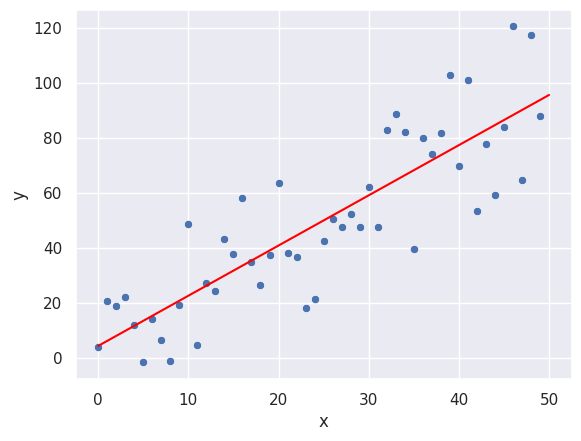

In [ ]:
import random
import pandas as pd
import seaborn as sns
sns.set()

# data parameters
# implicit model parameters!
m = 2        # slope
b = -1       # intercept
# data set specs
n = 50       # number of points to generate
y_range = 30 # governs the level of noise on the y coordinate
y_noise = \
  pd.Series([random.uniform(-y_range,y_range) for _ in range(n)])

# generate a dataframe for our data points
x = pd.DataFrame({'x':[i for i in range(n)]})
y = pd.DataFrame({'y': m * x['x'] + b + y_noise})
data_df = pd.concat([x,y], axis=1)

# linear regression model
# fit the model to our noisy data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
# NOTE: the fit function wants a dataframe for the independent var
# but it wants series for the dependent var!
model.fit(data_df[['x']], data_df['y'])

# plot the model together with the data
# create a dataframe that represents the model using two points
xfit = pd.DataFrame({'x':[0,n]})
yfit = pd.DataFrame({'y':model.predict(xfit)})
model_df = pd.concat([xfit, yfit], axis=1)

sns.scatterplot(data=data_df, x='x', y='y')  # data
sns.lineplot(data=model_df, x='x', y='y', color='red')  # model

# print model parameters
print("Slope: {:3.2f}".format(model.coef_[0]))
print("Intercept: {:3.2f}".format(model.intercept_))

# compute the R^2 score
rs = model.score(x,y)
print("R^2 score: {:3.2f}".format(rs))

# Another Look at the $R^2$ Score

The $R^2$ score is a score that compares the errors squared of the regression model to the errors squared of a default model.
The default model is just the average value $\bar{y}$ of all y-values.  That is, for any x-value the model always returns the same answer: $\bar{y}$.

<img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/rs.png" height="400" width="460">

(Source: [Wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination))

Let's explore that figure a little bit more assuming that we have a training dataset that consists of the set of points,

$\{(x_1,y_1), (x_2,y_2),\dots,(x_n,y_n)\}$

where $x_i$ are the values of the independent variable and $y_i$ are the values of the dependent variable. Then the we have the following definitions,

1. The **default model** is defined as $\bar{y} = \frac{1}{n}\sum_{i=1}^n y_i$, the average of the expected outcomes $y_i$ of the training data.
1. The regression model is $f$ and the **residuals** are defined as $y_i - f(x_i)$ for $i=1\ldots n$, that is, a residual is the difference between the expected outcome $y_i$ at point $x_i$ minus the outcome computed by the model $f(x_i)$.
1. $SS_{\rm res}$ is the squared sum of the residuals of the model $f$, more precisely, $SS_{\rm res} = \sum_{i=1}^n (y_i - f(x_i))^2$.
1. $SS_{\rm tot}$ is the squared sum of the residuals of the default model $\bar{y}$, more precisely, $SS_{\rm tot} = \sum_{i=1}^n (y_i - \bar{y})^2$.

With these definitions we can now compute the $R^2$ score as

$R^2
= 1 - \frac{SS_{\rm res}}{SS_{\rm tot}}
= 1 - \frac{\sum_{i=1}^n (y_i - f(x_i))^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$

Notice that if the performance of our regression model $f$ approaches the performance of our default model $\bar{y}$ then the
score will be,

$R^2 \approx 1 - 1 = 0$

If our model $f$ is perfect, that is, all residuals $y_i - f(x_i)$ are equal to zero then we obtain the score,

$R^2 = 1 - 0 = 1$

That means, the closer an $R^2$ score is to one the better the model.  It turns out that if our model $f$ is worse than the default model $\bar{y}$ then it is possible to obtain negative $R^2$ values.

# Regression Models

Turns out that all the classification models we have covered so far also support regression models:

* Regression Trees (we have seen these before when we discussed non-linear regression)
* KNN Regression Models
* MLP Regression Models

## Regression Trees

Below is the code to construct a regression tree on the cars dataset.  Here we restrict the complexity of the tree to a depth of 2.

R^2 score: 0.73 (0.60, 0.85)


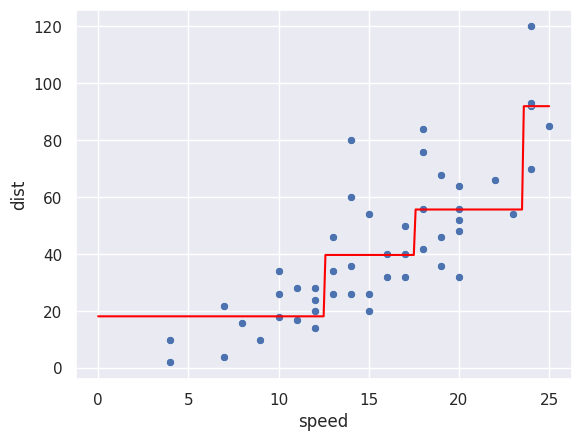

In [ ]:
import seaborn as sns
import pandas as pd
from confint import regression_confint

# get our dataset
cars_df = pd.read_csv(home+"cars.csv")

# pick model
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=2)
model.fit(cars_df[['speed']],cars_df['dist'])

# plot the data
sns.scatterplot(data=cars_df, x='speed', y='dist')

# plot the model
# 0 to 25 in .1 increments
x_ticks = pd.DataFrame(list(range(0,251)), columns=['speed']) / 10.0
y_ticks = pd.DataFrame(model.predict(x_ticks), columns=['dist'])
model_df = pd.concat([x_ticks, y_ticks], axis=1)
sns.lineplot(model_df, x='speed', y='dist', color='red')

# compute the R^2 score
rs = model.score(cars_df[['speed']],cars_df['dist'])
obs = cars_df.shape[0]
vars = 1
lb, ub = regression_confint(rs, obs, vars)
print("R^2 score: {:3.2f} ({:3.2f}, {:3.2f})".format(rs,lb,ub))

## KNN Regression

KNN regression is interesting in that we are not asking the neighbors for a majority label but instead we compute the average value associated with the neighbors and that becomes the value of the current point.

R^2 score: 0.75 (0.64, 0.86)


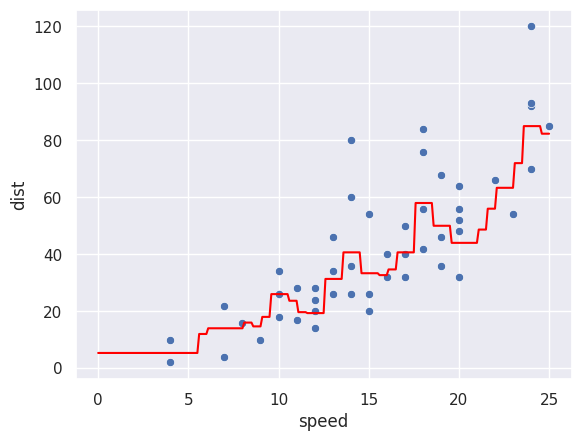

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from confint import regression_confint

# get our dataset
cars_df = pd.read_csv(home+"cars.csv")

# pick model
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=3)
model.fit(cars_df[['speed']],cars_df['dist'])

# plot the data
sns.scatterplot(data=cars_df, x='speed', y='dist')

# plot the model
# 0 to 25 in .1 increments
x_ticks = pd.DataFrame(list(range(0,251)), columns=['speed']) / 10.0
y_ticks = pd.DataFrame(model.predict(x_ticks), columns=['dist'])
model_df = pd.concat([x_ticks, y_ticks], axis=1)
sns.lineplot(model_df, x='speed', y='dist', color='red')

# compute the R^2 score
rs = model.score(cars_df[['speed']],cars_df['dist'])
obs = cars_df.shape[0]
vars = 1
lb, ub = regression_confint(rs, obs, vars)
print("R^2 score: {:3.2f} ({:3.2f}, {:3.2f})".format(rs,lb,ub))

## MLP Regression

In MLP regression we ask the network to model a continuous value.  This turns out to be just a change in interpretation of the output value.  Rather than applying a thresholding function to the output like the `sign` function we just use the raw output value as the model output value.

R^2 score: 0.70 (0.57, 0.84)


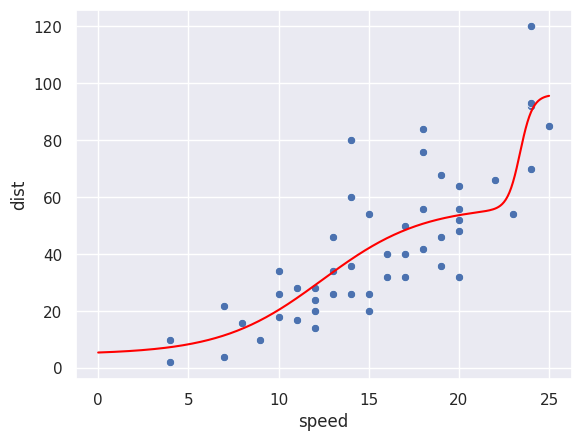

In [ ]:
import seaborn as sns
import pandas as pd
from confint import regression_confint

# get our dataset
cars_df = pd.read_csv(home+"cars.csv")

# pick model
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(2,),
                     activation='tanh',
                     max_iter=100000)
model.fit(cars_df[['speed']],cars_df['dist'])

# plot the data
sns.scatterplot(data=cars_df, x='speed', y='dist')

# plot the model
# 0 to 25 in .1 increments
x_ticks = pd.DataFrame(list(range(0,251)), columns=['speed']) / 10.0
y_ticks = pd.DataFrame(model.predict(x_ticks), columns=['dist'])
model_df = pd.concat([x_ticks, y_ticks], axis=1)
sns.lineplot(model_df, x='speed', y='dist', color='red')

# compute the R^2 score
rs = model.score(cars_df[['speed']],cars_df['dist'])
obs = cars_df.shape[0]
vars = 1
lb, ub = regression_confint(rs, obs, vars)
print("R^2 score: {:3.2f} ({:3.2f}, {:3.2f})".format(rs,lb,ub))

# Regression and Grid Search: Tree Regression

Just like in classification, regression models are built using a small sample of a possibly infinite data universe and we have to estimate the model parameters for the best model using this small sample...that means we have to perform a grid search over parameter ranges and we want to use cross-validation to minimize the bias of any one particular training-test split of the data.

Let's try this with tree regression.

R^2 score: 0.76 (0.66, 0.87)


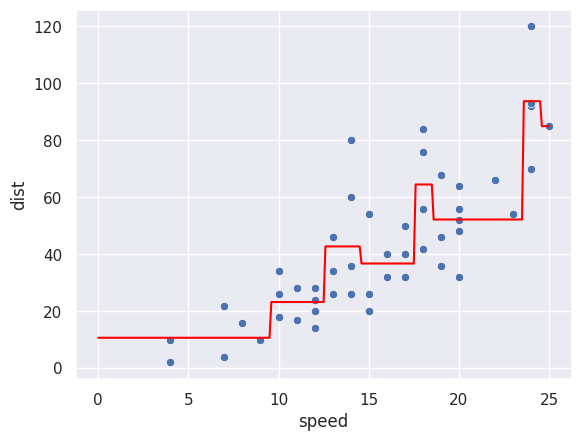

In [ ]:
# Import the necessary modules and libraries
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from confint import regression_confint
import pandas as pd

# get our dataset
cars_df = pd.read_csv(home+"cars.csv")

# setting up grid search
model = DecisionTreeRegressor()
param_grid = {'max_depth': list(range(1,11))}
grid = GridSearchCV(model, param_grid, cv=5)

# performing grid search
grid.fit(cars_df[['speed']], cars_df['dist'])
best_model = grid.best_estimator_

# plot the data
sns.scatterplot(data=cars_df, x='speed', y='dist')

# plot the model
# 0 to 25 in .1 increments
x_ticks = pd.DataFrame(list(range(0,251)), columns=['speed']) / 10.0
y_ticks = pd.DataFrame(best_model.predict(x_ticks), columns=['dist'])
model_df = pd.concat([x_ticks, y_ticks], axis=1)
sns.lineplot(model_df, x='speed', y='dist', color='red')

# compute the R^2 score
rs = best_model.score(cars_df[['speed']],cars_df['dist'])
obs = cars_df.shape[0]
vars = 1
lb, ub = regression_confint(rs, obs, vars)
print("R^2 score: {:3.2f} ({:3.2f}, {:3.2f})".format(rs,lb,ub))

Try to do a grid search for k-NN and ANNs.